# 1. Initializations and Dataset Download

In [16]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification")

Skipping, found downloaded files in ".\bean-leaf-lesions-classification" (use force=True to force download)


# 2. Imports
We begin by importing the necessary libraries. Note that PyTorch does not automatically utilize the GPU for training; the device must be explicitly set to 'cuda' for NVIDIA GPUs. For users on Apple Silicon (e.g., M1 or M2 chips), 'cuda' should be replaced with 'mps' to enable hardware acceleration.

In [17]:
# Importing necessary libraries and modules

import torch  # Core PyTorch library
from torch import nn  # Module for building neural network layers and loss functions
from torch.optim import Adam  # Adam optimizer

import torchvision.transforms as transforms  # Tools for preprocessing and augmenting images
from torchvision import models  # Pre-trained models provided by PyTorch

from torch.utils.data import Dataset, DataLoader  # Classes for creating custom datasets and loading data efficiently

from sklearn.preprocessing import LabelEncoder  # Utility to encode categorical labels into numerical format

import matplotlib.pyplot as plt  # Library for visualizing images and plotting metrics
from PIL import Image  # Python Imaging Library for image loading and processing

import pandas as pd  # Library for handling tabular data and CSV files
import numpy as np  # Library for numerical and matrix operations
import os  # Operating system module for handling file paths

# Setting the computation device
# Use GPU if available; otherwise, fall back to CPU.
# For Apple Silicon (e.g., M1/M2), replace 'cuda' with 'mps'.
device = "cuda" if torch.cuda.is_available() else "cpu"


# 3. Reading Data Paths
The following code traverses a nested directory structure in which images are organized into subdirectories, each representing a distinct label or category. It collects the file paths of all images along with their associated labels, and stores this information in a pandas DataFrame. This structured format facilitates further data preprocessing.

Note that at this stage, the entire dataset is read into memory. The data will be subsequently split into training, validation, and testing subsets for model development and evaluation.

In [18]:
# Reading the training and validation data from CSV files

train_df = pd.read_csv("D:/PyTorchTutorial/bean-leaf-lesions-classification/train.csv")  # Load training data
val_df = pd.read_csv("D:/PyTorchTutorial/bean-leaf-lesions-classification/val.csv")  # Load validation data

# Combine the training and validation datasets into one DataFrame
data_df = pd.concat([train_df, val_df], ignore_index=True)

# Construct the full image file paths by appending the relative paths from the CSV to the base directory
data_df["image:FILE"] = "D:/PyTorchTutorial/bean-leaf-lesions-classification/" + data_df["image:FILE"]

# Display the shape of the combined dataset and preview the first few rows
print("Data shape is: ", data_df.shape)
print()
data_df.head()


Data shape is:  (1167, 2)



,image:FILE,category
0,D:/PyTorchTutorial/bean-leaf-lesions-classific...,0
1,D:/PyTorchTutorial/bean-leaf-lesions-classific...,0
2,D:/PyTorchTutorial/bean-leaf-lesions-classific...,0
3,D:/PyTorchTutorial/bean-leaf-lesions-classific...,0
4,D:/PyTorchTutorial/bean-leaf-lesions-classific...,0


# 4. Data Inspection
Before proceeding with the model training, it is crucial to inspect the dataset to ensure its integrity and understand its structure. This step helps identify potential issues such as missing or incorrect data, as well as to gain an overview of the distribution of images across different categories. The following code provides a basic inspection of the data by displaying its shape, column names, and a sample of the data.

In [19]:
# Inspecting the class distribution and unique categories in the dataset

# Display the unique classes (categories) in the dataset
print("Classes are: ")
print(data_df["category"].unique())
print()

# Show the distribution of images across the different categories
print("Class distribution is: ")
print(data_df["category"].value_counts())

Classes are: 
[0 1 2]

Class distribution is: 
category
2    393
1    389
0    385
Name: count, dtype: int64


# 5. Data Split
To properly split the dataset into training and testing subsets, we will take an alternative approach. Instead of manually handling image files, we will first split the DataFrame itself and then read the image paths.

We will randomly sample 70% of the data for the training set using data_df.sample(frac=0.7, random_state=7). The remaining 30% will be designated as the testing set by removing the indices corresponding to the training set using data_df.drop(train.index). This ensures that the training and testing sets are distinct and properly randomized.

The final data split is as follows:

* Training: 70%
* Testing: 30%

In [20]:
# Splitting the dataset into training and testing sets

# Create a training set by randomly sampling 70% of the data
train = data_df.sample(frac=0.7, random_state=7)

# Create a testing set by removing the 70% of the data used for training
test = data_df.drop(train.index)

# 6. Preprocessing Objects
In this step, we will create preprocessing objects to prepare our data for model training.

First, we will use a LabelEncoder to convert string-based class labels into numeric values. For example, classes like "cat" and "dog" will be transformed into numerical values like 0 and 1, respectively. This is necessary because machine learning models process numerical data, not strings.

Next, we will create an image transformation object to preprocess the images. This object will ensure that all images are resized to a consistent size and converted into tensors of type float. These transformations help standardize the images and make them suitable for input into the model. The transformation object can also perform additional operations, such as normalization or augmentation. You can explore more details about the available transformations in the official documentation.

In [21]:
# Creating preprocessing objects for data

# Initialize the LabelEncoder to convert string labels into numeric values
label_encoder = LabelEncoder()

# Define the image transformation pipeline
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize all images to 128x128 for consistency
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.ConvertImageDtype(torch.float),  # Ensure image values are in floating-point format
])  # This transforms all images into a unified format for model input

# 7. Custom Dataset Class
In this step, we will create a custom dataset class to handle our data more efficiently during model training. This class will inherit from PyTorch's Dataset class, allowing us to leverage its functionality while customizing it for our specific needs. By converting our data into a PyTorch Dataset object, we ensure that it is handled efficiently during training, particularly when working with large datasets.

The concept behind inheritance is simple: PyTorch provides a base class with several built-in functions, and we will extend this class by overriding some of its methods to suit our requirements.

1. Key Steps:
Constructor (__init__):
In the constructor, we define our dataset by accepting a DataFrame that contains image paths and labels. We also initialize the image preprocessing pipeline using the transform object we created earlier. For the labels, we apply the LabelEncoder to convert them from string labels (e.g., "cat", "dog") to numerical values (e.g., 0, 1) using the fit_transform() method.

2. Efficient Data Handling:
Rather than reading the images during initialization (which would be time-consuming), we defer image loading to the __getitem__() method. This method will read an individual image, apply the necessary preprocessing transformations, and return the processed image along with its corresponding encoded label.

In [22]:
# Custom dataset class for loading and processing images

class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        """
        Initializes the dataset by storing the dataframe and setting up
        the necessary transformations and label encoding.
        
        Args:
            dataframe (pandas.DataFrame): DataFrame containing image paths and labels.
            transform (callable, optional): A function/transform to apply to the images.
        """
        self.dataframe = dataframe  # Store the DataFrame with image paths and labels
        self.transform = transform  # Store the transformation function
        # Encode labels and store as a tensor on the appropriate device
        self.labels = torch.tensor(label_encoder.fit_transform(dataframe['category'])).to(device)

    def __len__(self):
        """
        Returns the number of samples in the dataset.
        
        Returns:
            int: Total number of images in the dataset.
        """
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        """
        Retrieves the image and its corresponding label at the specified index.
        
        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: (image, label) where image is the preprocessed image and label is the corresponding class label.
        """
        # Get the image path and label for the specified index
        img_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]
        
        # Open the image and convert it to RGB format
        image = Image.open(img_path).convert('RGB')
        
        # Apply transformations if provided
        if self.transform:
            image = (self.transform(image) / 255).to(device)  # Normalize and convert image to tensor

        return image, label

# 8. Create Dataset Objects
In this step, we will create two dataset objects—one for training and one for testing. These objects will be instantiated using the respective DataFrames (train and test) that we created earlier, along with the transform object we defined for preprocessing the images.

By using the same transform object for both datasets, we ensure that all images undergo consistent preprocessing, which is crucial for maintaining uniformity in the model's input data.

In [23]:
# Create dataset objects for the training and testing datasets

# Instantiate the CustomImageDataset for the training data
train_dataset = CustomImageDataset(dataframe=train, transform=transform)

# Instantiate the CustomImageDataset for the testing data
test_dataset = CustomImageDataset(dataframe=test, transform=transform)

# 9. Visualize Images
This step is optional and does not impact the model's accuracy. The purpose of this step is to visually inspect a random selection of images from the dataset to get an overview of the data. Using the matplotlib package, we will display 9 random images, which can be helpful for understanding the data distribution and verifying that the images are correctly loaded and preprocessed.

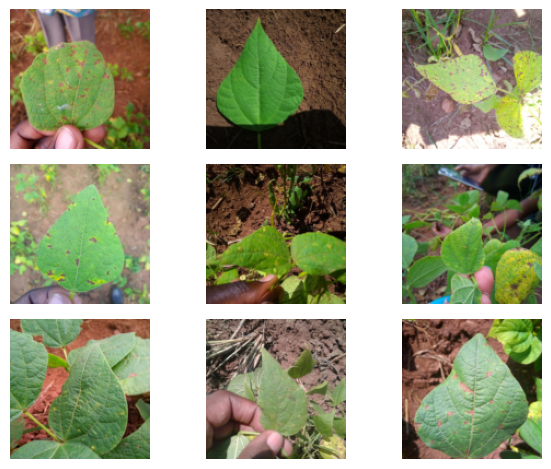

In [24]:
# Visualizing 9 random images from the training dataset

# Set the number of rows and columns for displaying the images
n_rows = 3
n_cols = 3

# Create a subplot with the specified number of rows and columns
f, axarr = plt.subplots(n_rows, n_cols)

# Loop through the grid of subplots
for row in range(n_rows):
    for col in range(n_cols):
        # Select a random image from the training dataset
        image = train_dataset[np.random.randint(0, train_dataset.__len__())][0].cpu()
        
        # Display the image in the corresponding subplot
        axarr[row, col].imshow((image * 255).squeeze().permute(1, 2, 0))  # Rescale image and adjust dimensions
        axarr[row, col].axis('off')  # Turn off axis for a cleaner presentation

# Adjust layout for better spacing and display the plot
plt.tight_layout()
plt.show()

# 10. Hyperparameters
In this section, we define the key hyperparameters required for training the model. These hyperparameters control aspects such as the batch size, the number of epochs, and the learning rate, which are crucial for determining the efficiency and effectiveness of the model training process.

* Batch Size: This parameter specifies the number of samples that will be processed before the model's internal parameters are updated.

* Number of Epochs: This is the number of times the entire dataset will be passed through the model during training.

* Learning Rate: This controls the step size at each iteration while moving toward a minimum of the loss function. A proper learning rate ensures efficient training without overshooting or stagnating.

In [25]:
# Set the training hyperparameters
LR = 1e-3        # Learning rate for model training
BATCH_SIZE = 4   # Number of samples per batch
EPOCHS = 15      # Number of training epochs

# 11. DataLoader Setup
In this step, we create the DataLoader objects for both the training and testing datasets. The DataLoader is responsible for efficiently loading the dataset in batches during model training and evaluation. By specifying the batch size and enabling shuffling, the DataLoader ensures that the model is trained with a diverse set of samples in each epoch.

* Training DataLoader: This DataLoader loads the training data in batches of the specified size (BATCH_SIZE = 4) and shuffles the data before each epoch to prevent the model from learning any unintended patterns from the data order.

* Testing DataLoader: Similar to the training DataLoader, but used for loading the test data. The batch size remains the same, and shuffling is enabled to ensure a random evaluation.

In [26]:
# Create DataLoader objects for the training and testing datasets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# 12. Model Setup
In this section, we load the pre-trained GoogleNet model from the PyTorch torchvision.models library. GoogleNet (also known as Inception v1) is a popular deep learning architecture known for its efficiency in terms of computational cost and accuracy.

* Pre-trained GoogleNet: The model is loaded with the default pre-trained weights. This allows us to take advantage of the knowledge learned from a large dataset (e.g., ImageNet), which can improve performance, especially when the dataset is small or when training from scratch is computationally expensive.

* Fine-tuning the model: The loop through googlenet_model.parameters() ensures that the gradients for all parameters of the model are enabled (requires_grad=True), allowing us to fine-tune the model during training. By default, when using a pre-trained model, some layers may have their gradients frozen. This code ensures all layers will be updated during training.

In [27]:
# Load the pre-trained GoogleNet model
googlenet_model = models.googlenet(weights='DEFAULT')

# Enable gradient computation for all model parameters to allow fine-tuning
for param in googlenet_model.parameters():
    param.requires_grad = True

# 13. Accessing the Fully Connected (FC) Layer
In this step, googlenet_model.fc accesses the fully connected (FC) layer of the pre-trained GoogleNet model. The fully connected layer is typically the last layer in the network and is responsible for producing the final predictions (classification results).

* Purpose: The fc layer often needs to be modified when fine-tuning a pre-trained model for a new task, especially when the number of output classes in the new task differs from the original model’s task (e.g., 1000 classes for ImageNet).

* Modification: You can replace this layer with a custom one suited to your specific task, such as adjusting the number of output units to match the number of classes in your dataset.

In [28]:
# Access the fully connected (fc) layer of the GoogleNet model
googlenet_model.fc

Linear(in_features=1024, out_features=1000, bias=True)

# 14. Customizing the Fully Connected Layer
In this section, we modify the fully connected (FC) layer of the pre-trained GoogleNet model to match the number of classes in our specific dataset. The original GoogleNet model was trained on ImageNet, which has 1000 classes. However, we need to adapt the model for our task, which likely has a different number of categories.

* Number of Classes: We first determine the number of unique categories (labels) in the dataset using len(data_df["category"].unique()), which returns the count of distinct classes in the category column of the DataFrame.

* Replacing the FC Layer: The googlenet_model.fc layer is replaced with a new torch.nn.Linear layer. The new layer has an input size equal to the number of features from the previous layer (googlenet_model.fc.in_features) and an output size equal to the number of classes (num_classes) in our dataset.

* Moving the Model to the Device: Finally, we move the modified model to the specified device (either GPU or CPU) using googlenet_model.to(device).

In [29]:
# Get the number of unique classes in the dataset
num_classes = len(data_df["category"].unique())

# Replace the fully connected layer with a new one that matches the number of classes
googlenet_model.fc = torch.nn.Linear(googlenet_model.fc.in_features, num_classes)

# Move the model to the device (GPU or CPU)
googlenet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

# 15. Loss Function and Optimizer
In this section, we define the loss function and the optimizer to be used during the training process.

* Loss Function (Criterion): We use CrossEntropyLoss, which is commonly used for multi-class classification tasks. This loss function computes the difference between the predicted class probabilities and the true labels. It is suitable when the model outputs class probabilities (using a softmax function) and the target labels are provided as class indices.

* Why CrossEntropyLoss: This is the standard loss function for classification problems, where each class is mutually exclusive. It combines log_softmax and negative log likelihood loss in a single function.

* Optimizer: We use the Adam optimizer with a learning rate of LR (0.001). Adam is an adaptive learning rate optimization algorithm that adjusts the learning rate for each parameter individually based on first and second moments of the gradients. It is known for being efficient and performing well across a wide range of problems.

* Why Adam: Adam generally converges faster than traditional optimizers like SGD (Stochastic Gradient Descent), especially for large datasets and deep networks.

In [30]:
# Define the loss function (Cross-Entropy Loss)
criterion = nn.CrossEntropyLoss()

# Define the optimizer (Adam)
optimizer = Adam(googlenet_model.parameters(), lr=LR)

# 16. Training Loop
In this section, we define the loop that will train the GoogleNet model over multiple epochs. The loop involves forwarding data through the model, calculating the loss, performing backpropagation, and updating the model's parameters using the optimizer. Additionally, we track the training loss and accuracy for each epoch.

* Epoch Loop: The training process is repeated for a predefined number of epochs (EPOCHS), which defines how many times the model will see the entire training dataset.

* Batch Loop: Inside each epoch, the model processes batches of data using the train_loader. For each batch, the following operations are performed:

1. Zeroing Gradients: optimizer.zero_grad() clears the accumulated gradients from the previous batch, ensuring that gradients are computed fresh for the current batch.

2. Model Forward Pass: The model generates predictions by forwarding the inputs through the network (outputs = googlenet_model(inputs)).

3. Loss Calculation: The loss is computed by comparing the model's predictions (outputs) with the true labels (labels) using the criterion (CrossEntropyLoss).

4. Backpropagation: train_loss.backward() calculates the gradients of the model’s parameters with respect to the loss.

5. Accuracy Calculation: The accuracy for the batch is calculated by comparing the predicted class (using torch.argmax) with the true labels, and the sum of correct predictions is added to the total accuracy.

6. Optimizer Step: optimizer.step() updates the model's parameters based on the calculated gradients.

* Loss and Accuracy Tracking: The training loss and accuracy are accumulated for the entire epoch and stored in lists (total_loss_train_plot and total_acc_train_plot) for later visualization.

In [31]:
# Lists to store training loss and accuracy for each epoch
total_loss_train_plot = []
total_acc_train_plot = []

# Training loop for the specified number of epochs
for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0

  # Loop through each batch in the training data
  for (inputs, labels) in train_loader:
    optimizer.zero_grad()  # Clear previous gradients
    outputs = googlenet_model(inputs)  # Forward pass: get model outputs
    train_loss = criterion(outputs, labels)  # Calculate loss
    total_loss_train += train_loss.item()  # Accumulate loss
    train_loss.backward()  # Backpropagate gradients

    # Calculate accuracy for the current batch
    train_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
    total_acc_train += train_acc  # Accumulate accuracy
    optimizer.step()  # Update model parameters

  # Store average loss and accuracy for the epoch
  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))

  # Print loss and accuracy for the epoch
  print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_dataset.__len__() * 100, 4)}%')
  print()

Epoch 1/15, Train Loss: 1.9411 Train Accuracy 56.6707%

Epoch 2/15, Train Loss: 1.7762 Train Accuracy 61.3219%

Epoch 3/15, Train Loss: 1.7298 Train Accuracy 62.4235%

Epoch 4/15, Train Loss: 1.7398 Train Accuracy 62.5459%

Epoch 5/15, Train Loss: 1.587 Train Accuracy 66.4627%

Epoch 6/15, Train Loss: 1.4419 Train Accuracy 70.7466%

Epoch 7/15, Train Loss: 1.3898 Train Accuracy 70.5018%

Epoch 8/15, Train Loss: 1.2088 Train Accuracy 77.4786%

Epoch 9/15, Train Loss: 1.2462 Train Accuracy 75.0306%

Epoch 10/15, Train Loss: 1.1589 Train Accuracy 78.7026%

Epoch 11/15, Train Loss: 1.0035 Train Accuracy 83.3537%

Epoch 12/15, Train Loss: 1.1626 Train Accuracy 76.4994%

Epoch 13/15, Train Loss: 1.0691 Train Accuracy 79.6818%

Epoch 14/15, Train Loss: 1.0387 Train Accuracy 81.0282%

Epoch 15/15, Train Loss: 0.8771 Train Accuracy 84.0881%



# 17. Testing Loop (Evaluation)
In this section, we evaluate the trained GoogleNet model on the test dataset. This process involves running the model on the test data without updating the model’s weights, as we are only interested in measuring the model's performance (i.e., its accuracy) after training.

* Disabling Gradient Calculation: We use torch.no_grad() to disable gradient computation during the evaluation phase. This reduces memory usage and speeds up computations since we don't need gradients for the test phase (we’re not performing backpropagation).

* Test Loop: The model makes predictions on the test data, and we calculate the accuracy:

1. Prediction: The model processes each batch in the test_loader and generates predictions (prediction = googlenet_model(input)).

2. Accuracy Calculation: For each batch, we calculate the accuracy by comparing the predicted class (torch.argmax(prediction, axis=1)) with the true labels (labels).

3. Accumulate Accuracy: The accuracy for each batch is accumulated in total_acc_test.

* Final Accuracy: After iterating through all the batches in the test set, we calculate the total accuracy by dividing total_acc_test by the size of the test dataset and multiplying by 100 to express it as a percentage.

In [32]:
# Testing loop (no gradient calculation)
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0

  # Loop through each batch in the test dataset
  for indx, (input, labels) in enumerate(test_loader):
    # Generate predictions for the current batch
    prediction = googlenet_model(input)

    # Calculate accuracy for the current batch
    acc = (torch.argmax(prediction, axis=1) == labels).sum().item()
    total_acc_test += acc  # Accumulate batch accuracy

# Calculate and print the total accuracy on the test set
print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__())*100, 2)}%")

Accuracy Score is: 77.43%


# 18. Visualization of Training Loss and Accuracy
In this section, we visualize the training progress over the epochs by plotting the training loss and accuracy. This helps in understanding how the model is performing during the training phase, whether it's improving, and if there are any signs of overfitting or underfitting.

* Plotting: We use matplotlib to create two subplots:

1. Training Loss: This subplot visualizes the training loss over the epochs.

2. Training Accuracy: This subplot visualizes the training accuracy over the epochs.

* fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5)): This creates a figure with two subplots (one row, two columns) to display the training loss and accuracy side by side. The figsize argument controls the size of the figure.

* Plot Training Loss:

* axs[0].plot(total_loss_train_plot, label='Training Loss'): This plots the total_loss_train_plot on the first subplot, showing how the loss decreases over time.

* The title, x-axis, and y-axis labels are set accordingly.

* Plot Training Accuracy:

* axs[1].plot(total_acc_train_plot, label='Training Accuracy'): This plots the total_acc_train_plot on the second subplot, showing how accuracy increases over time.

* The y-axis for accuracy is limited to the range [0, 100] using axs[1].set_ylim([0, 100]) to ensure that accuracy is displayed as a percentage.

* Legends: The legends for both plots are added using axs[0].legend() and axs[1].legend(), so it’s clear what each plot represents.

* plt.tight_layout(): Adjusts the spacing between the subplots to make sure they fit well within the figure and do not overlap.

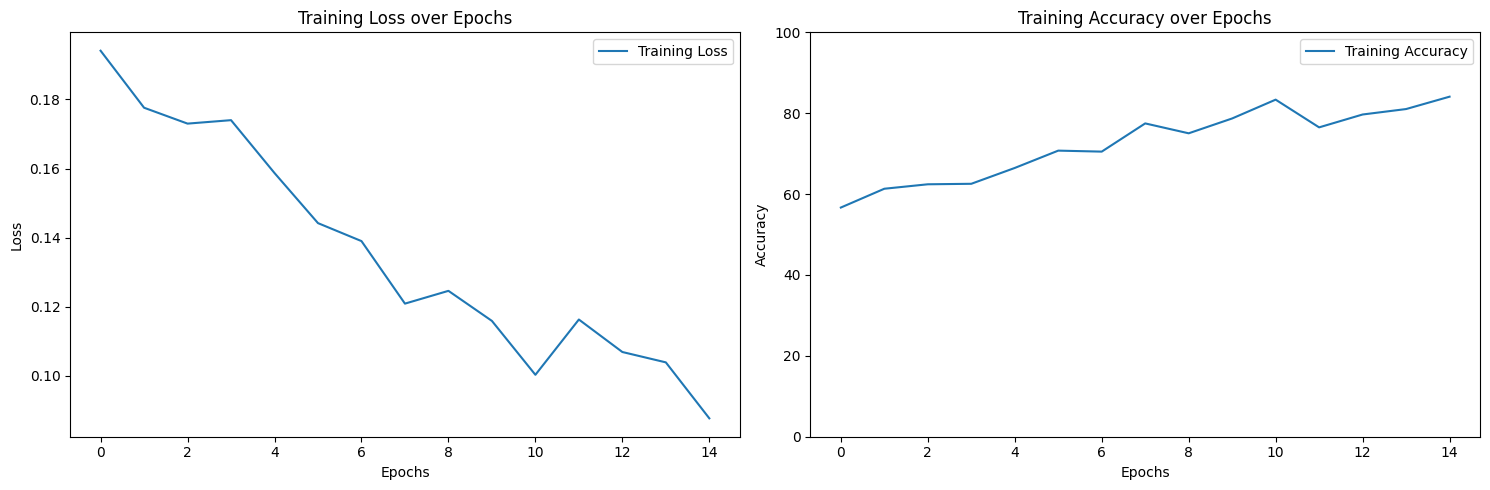

In [33]:
# Create subplots for training loss and accuracy
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot Training Loss
axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].set_title('Training Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].set_ylim([0, 2])  # Limit y-axis to range [0, 2] for better visualization of loss
axs[0].legend()

# Plot Training Accuracy
axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].set_title('Training Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])  # Limit y-axis to range [0, 100] for accuracy percentage
axs[1].legend()

# Adjust layout to avoid overlap
plt.tight_layout()

# Display the plots
plt.show()